In [1]:
#import some tools that we will use
import skimage.io
import skimage.measure
import skimage.feature
import skimage.segmentation
from skimage.morphology import disk
import scipy.ndimage
import numpy
import matplotlib.pyplot as plt
from generate_spot_positions import GenerateSpotPositionsJob
from models.image_filename_glob import ImageFilenameGlob

import scipy.ndimage
from pathlib import Path

In [2]:
#define paths to images
image_folder = "C:\\Users\\finne\\Documents\\python\\dropbox_test\\cell_crops\\"

# Image_path = "/Users/kevin/Desktop/generate_all_cropped_cell_images_output/Plate1_12-30-20_18-38-45_B02_T0001F002L01A02ZXXC03_cropped_117.npy"

well_ID = "B02"
field_ID = 5
channel_ID = 3

# Find 10 random nuclei
image_path = Path(image_folder)

image_filename_glob = image_path.glob(str(ImageFilenameGlob(well = well_ID, f = field_ID, c = channel_ID, suffix="_maximum_projection_nuclear_mask_???", extension="npy")))

images_selected_random = [next(image_filename_glob) for _ in range(10)]

for image_selected in images_selected_random:
    print(image_selected)

C:\Users\finne\Documents\python\dropbox_test\cell_crops\Plate1_12-30-20_18-38-45_B02_T0001F005L01A04ZXXC03_maximum_projection_nuclear_mask_001.npy
C:\Users\finne\Documents\python\dropbox_test\cell_crops\Plate1_12-30-20_18-38-45_B02_T0001F005L01A04ZXXC03_maximum_projection_nuclear_mask_002.npy
C:\Users\finne\Documents\python\dropbox_test\cell_crops\Plate1_12-30-20_18-38-45_B02_T0001F005L01A04ZXXC03_maximum_projection_nuclear_mask_003.npy
C:\Users\finne\Documents\python\dropbox_test\cell_crops\Plate1_12-30-20_18-38-45_B02_T0001F005L01A04ZXXC03_maximum_projection_nuclear_mask_004.npy
C:\Users\finne\Documents\python\dropbox_test\cell_crops\Plate1_12-30-20_18-38-45_B02_T0001F005L01A04ZXXC03_maximum_projection_nuclear_mask_005.npy
C:\Users\finne\Documents\python\dropbox_test\cell_crops\Plate1_12-30-20_18-38-45_B02_T0001F005L01A04ZXXC03_maximum_projection_nuclear_mask_006.npy
C:\Users\finne\Documents\python\dropbox_test\cell_crops\Plate1_12-30-20_18-38-45_B02_T0001F005L01A04ZXXC03_maximum_pro

In [18]:
# SET PARAMETERS HERE! 

# Contrast threshold is applied to the laplacian of the gaussian, it is fairly cryptic, so trial and error works best to find a good value.
contrast_threshold = 4

# Peak radius is applied to pre-filter the spots; anything smaller than this will get filtered out, so err on the small side. 
# It ought to be near the actual radius of the visible spot in pixels, though.
spot_peak_radius = 2

# Because your images are normalized to 0-1 range in the cell, your spot maxima are set to 1. So this ought to be the inverse of your overall signal:noise ratio
# Counterintuitively, better FISH -> lower threshold here -> less filtering taking place on the actual image
global_threshold = 0.3

segmenters = [GenerateSpotPositionsJob(image, "no_output", contrast_threshold, spot_peak_radius, global_threshold) for image in images_selected_random]

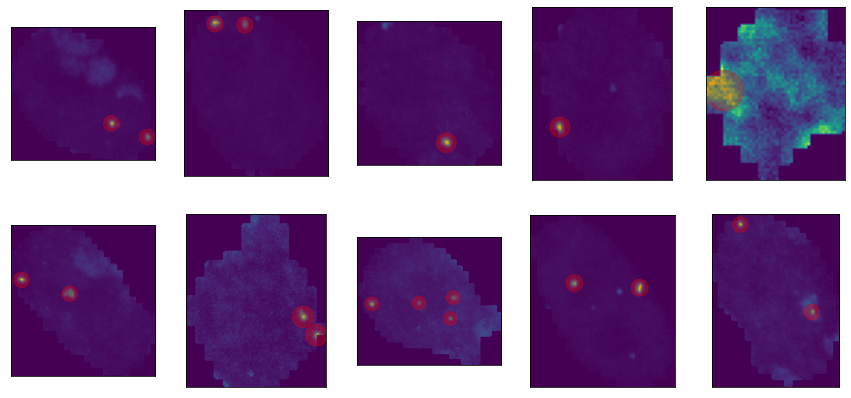

In [19]:
# display image and found spots -- these coordinates (+ offset) can be used to look up precalculated z-position and radial position. 
fig, axs = plt.subplots(2,5)

for i in range(0,10):
    ax = axs[i//5, i%5]
    ax.imshow(segmenters[i].image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for spot in segmenters[i].spots:
        circle=plt.Circle((spot[1], spot[0]), 7, color='r', alpha=0.3)
        ax.add_patch(circle)

fig.set_size_inches(15,7)
fig.canvas.draw()

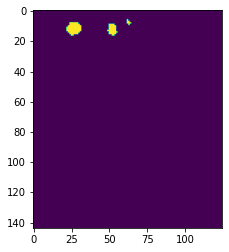

In [14]:
# read in config file into hash
# change hash as needed to reflect parameters above
# overwrite config file with new values

contrast_test = segmenters[1].image > 0.1

plt.imshow(contrast_test)
plt.show()